# **Kernel SVM을 통한 모델 적합**

기존 선형 SVM이 아닌 kernel SVM을 통해서 학습을 진행할경우,
간단한 예제데이터를 통해서 시각화 해보록 하겠습니다.

또한, 분류 결정 경계면을 결정하게 되는 Support Vector을 표시해보도록 하겠습니다.


In [1]:
%matplotlib inline

from sklearn.datasets import make_blobs
import mglearn
from mpl_toolkits.mplot3d import Axes3D, axes3d
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.cm as cm

import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
# 2차원 데이터, binary class
X, y = mglearn.tools.make_handcrafted_dataset()

---

# **Kernel SVM 의 hyperparameter**


<p align="center"><img width="400" height="auto" src="./images/gaussian.png"></p>

$$ k(x,x^{'}) = \frac{\exp(-{||x-x^{'}||}^2)}{\sigma} = \exp(-\gamma{||x-x^{'}||}^2)$$

<p align="center"><img width="700" height="auto" src="./images/gamma.png"></p>

<p align="center"><img width="700" height="auto" src="./images/c.png"></p>

In [3]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=10, gamma=0.1)
fitted_model = model.fit(X, y)

In [4]:
# support vectors
sv = fitted_model.support_vectors_
sv

array([[ 8.1062269 ,  4.28695977],
       [ 9.50169345,  1.93824624],
       [11.563957  ,  1.3389402 ],
       [10.24028948,  2.45544401],
       [ 7.99815287,  4.8525051 ]])

In [5]:
# dual_coef_ 의 부호에 의해 서포트 벡터의 클래스 레이블이 결정
sv_coef = fitted_model.dual_coef_.ravel()
sv_coef

array([-10.        ,  -6.25138167,  -3.73425365,  10.        ,
         9.98563532])

In [6]:
sv_labels = sv_coef > 0
sv_labels

array([False, False, False,  True,  True])

Text(0, 0.5, 'Attribute 1')

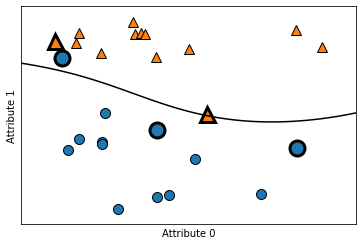

In [7]:
# black line
# eps: scale down
mglearn.plots.plot_2d_separator(fitted_model, X, eps=0.5)

# data points
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors as marker size
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)

plt.xlabel("Attribute 0")
plt.ylabel("Attribute 1")

---

# **Kernel SVM 의 hyperparameter 예시**


동일한 데이터를 가지고 RBF kernel SVM의 학습 파리미터인 'C'와 'Gamma'를 변화시켜 가면서,
    분류 경계면과 이를 결정하게 되는 Support Vector들의 변화를 시각화하여 확인해 보도록 하겠습니다.


Figure(1440x720)
[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]]


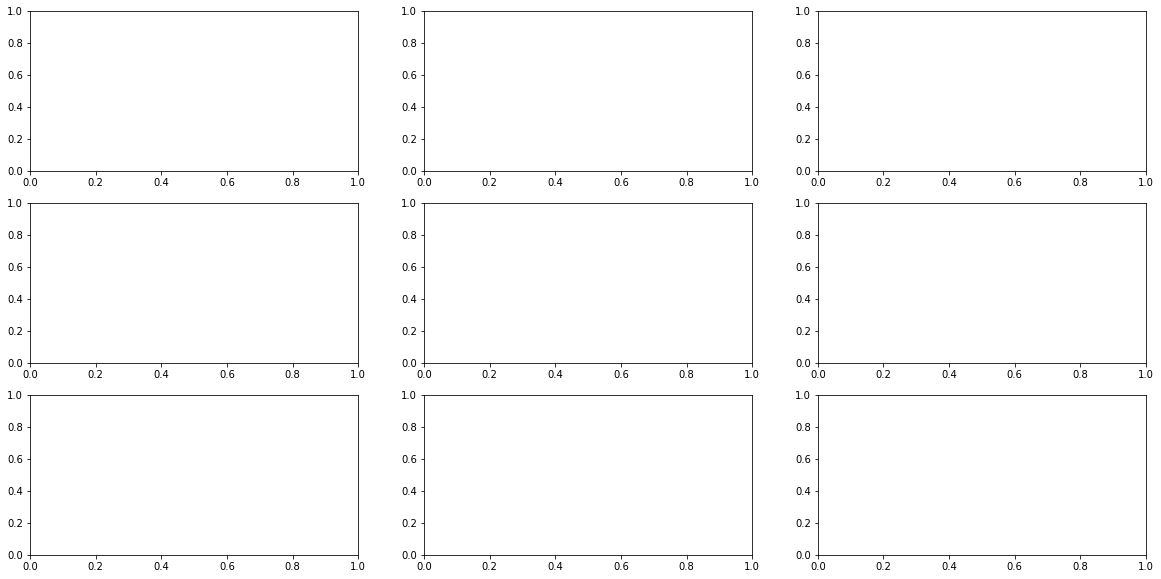

In [8]:
# subplots(# of row, # of col)
# figsize = (가로 길이, 세로 길이)
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
print(fig)
print(axes)

In [9]:
zip(axes, [-1, 0, 3])

In [10]:
list(zip(axes, [-1, 0, 3]))

[(array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object), -1),
 (array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object), 0),
 (array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object), 3)]

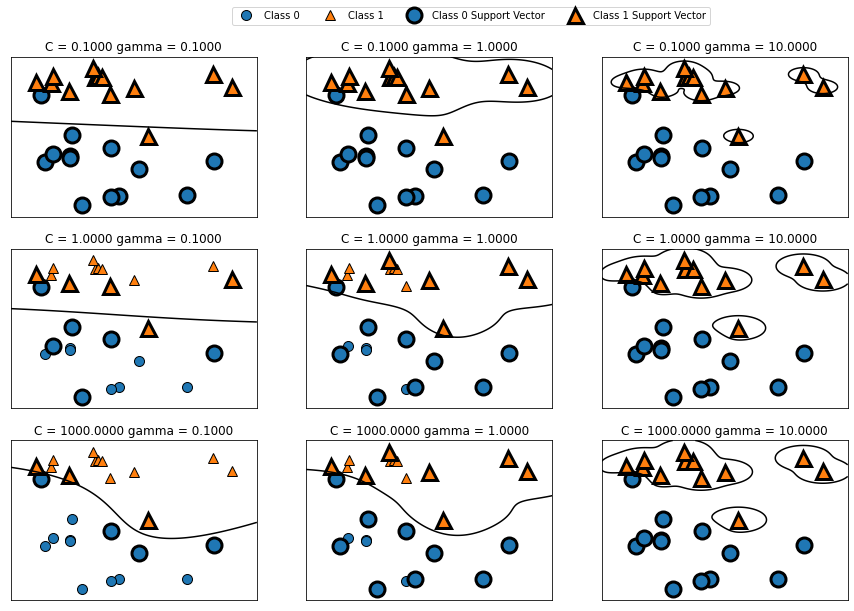

In [11]:
#  Cost 와 Gamma에 따른 SCM 분류결정 경계면
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    # at first: 
    # ax = [axis(1,1), axis(1,2), axis(1,3)]
    # C = -1
    for a, gamma in zip(ax, range(-1, 2)): # -1,0,1
        # at first: 
        # a = axis(1,1)
        # gamma = -1
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

        
# axes[i, j]: title 입력 위치 시작점
# loc: title 위치 조정
# ncol
axes[0, 0].legend(["Class 0", "Class 1", "Class 0 Support Vector", "Class 1 Support Vector"],
                  ncol=4, loc=(.9, 1.2))


---

# **Kernel SVM 의 hyperparameter tunning with *GridSearch***

동일한 방식으로 분류경계면을 contour형태를 통해 시각해 보도록하겠습니다.
또한, 'C'와 'Gamma'에 따른 검증데이터의 분류성능을 통해서 최적의 parmeter를 확인해보도록 하겠습니다.


```python
from sklearn.datasets import load_iris
iris = load_iris()
import pickle
with open('../data/svr/iris.pkl','wb') as f:
    pickle.dump(iris,f)
```

In [38]:
import pickle
with open('../data/svr/iris.pkl','rb') as f:
    iris = pickle.load(f)

In [39]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [40]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

<p align="center"><img width="700" height="auto" src="./images/iris.png"></p>

## 시각화를 위한 2개의 변수와 2개의 클래스만을 사용

In [19]:
# Iris 
X = iris['data']
y = iris['target']

X_2d = X[:, :2]
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

- 사용 데이터 scaling

In [20]:
X_2d[0:5]

array([[7. , 3.2],
       [6.4, 3.2],
       [6.9, 3.1],
       [5.5, 2.3],
       [6.5, 2.8]])

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)
X_2d[0:5]

array([[ 1.11900931,  0.99068792],
       [ 0.20924564,  0.99068792],
       [ 0.96738203,  0.68864892],
       [-1.15539985, -1.72766308],
       [ 0.36087292, -0.21746808]])

In [22]:
y_2d

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## GridSearchCV: 
- hyperparameters를 바꿔주면서 SVM모델을 학습하여 best hyperparameters를 확인
- C(3개)x Gamma(3개) = 총 9개의 파라미터 환경에서 모델을 학습을 수행
- `scoring`: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter (‘accuracy’, ‘balanced_accuracy’, ‘f1’)

```python
grid = GridSearchCV(model, parameter_dict, cross_validation, scoring="f1") # 실험 설계도
grid.fit(X, y) # 실험시작
grid # fit된 grid는 어떤 결과물을 가지고 있음
```

In [23]:
# model
SVC()

SVC()

In [24]:
C_range = [1e-2, 1, 1e2]
C_range

[0.01, 1, 100.0]

In [25]:
gamma_range =[1e-2, 1e-1, 1]
gamma_range

[0.01, 0.1, 1]

In [26]:
param_grid = {'gamma': gamma_range, 'C':C_range}
param_grid

{'gamma': [0.01, 0.1, 1], 'C': [0.01, 1, 100.0]}

In [27]:
# GridSearchCV에 사용되는 partition 함수
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv

StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None)

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
scoring = make_scorer(f1_score, average = 'binary')

In [29]:
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv, scoring=scoring )
grid

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': [0.01, 1, 100.0], 'gamma': [0.01, 0.1, 1]},
             scoring=make_scorer(f1_score, average=binary))

In [30]:
grid.fit(X_2d, y_2d)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 1, 'gamma': 1} with a score of 0.69


In [31]:
grid.best_params_

{'C': 1, 'gamma': 1}

- to list

---

- 파라미터 환경에 따른 각각의 모델 분류 결정 경계면 시각화를 위한 9개 모델 환경 정의

In [32]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-2, 1e-1, 1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

In [33]:
classifiers

[(0.01, 0.01, SVC(C=0.01, gamma=0.01)),
 (0.01, 0.1, SVC(C=0.01, gamma=0.1)),
 (0.01, 1, SVC(C=0.01, gamma=1)),
 (1, 0.01, SVC(C=1, gamma=0.01)),
 (1, 0.1, SVC(C=1, gamma=0.1)),
 (1, 1, SVC(C=1, gamma=1)),
 (100.0, 0.01, SVC(C=100.0, gamma=0.01)),
 (100.0, 0.1, SVC(C=100.0, gamma=0.1)),
 (100.0, 1, SVC(C=100.0, gamma=1))]

In [34]:
list(enumerate(classifiers))

[(0, (0.01, 0.01, SVC(C=0.01, gamma=0.01))),
 (1, (0.01, 0.1, SVC(C=0.01, gamma=0.1))),
 (2, (0.01, 1, SVC(C=0.01, gamma=1))),
 (3, (1, 0.01, SVC(C=1, gamma=0.01))),
 (4, (1, 0.1, SVC(C=1, gamma=0.1))),
 (5, (1, 1, SVC(C=1, gamma=1))),
 (6, (100.0, 0.01, SVC(C=100.0, gamma=0.01))),
 (7, (100.0, 0.1, SVC(C=100.0, gamma=0.1))),
 (8, (100.0, 1, SVC(C=100.0, gamma=1)))]

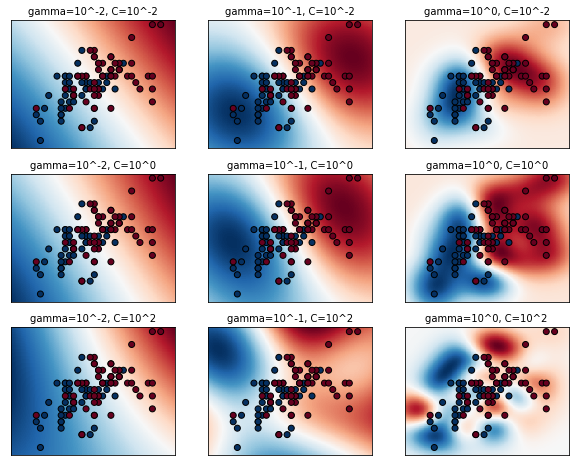

In [35]:
plt.figure(figsize=(10, 8))

xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))

for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu_r)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')

    # remove ticks
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

- Cross validation에 구해진 Accuracy

In [36]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
print('shape:', scores.shape)
print('values:', scores)

shape: (3, 3)
values: [[0.63072384 0.64333333 0.66573427]
 [0.62979602 0.67444733 0.69166808]
 [0.63971429 0.67223074 0.61      ]]


Text(0.5, 1.0, 'Validation Accuracy')

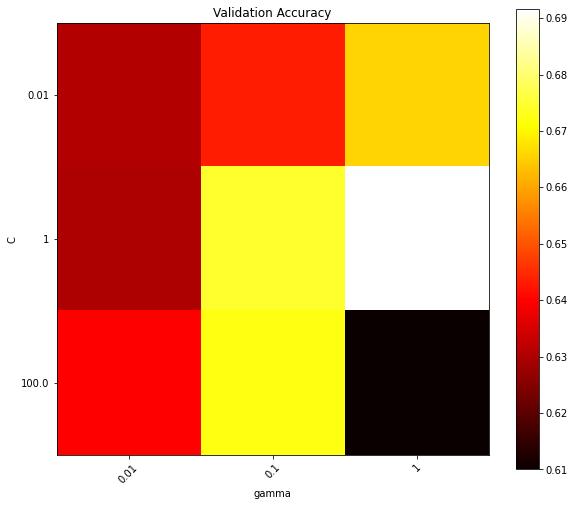

In [37]:
# Heat_map을 통한 Gamma 와 C에 따른 정확도 요약
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)

plt.xlabel('gamma')
plt.ylabel('C')

plt.colorbar()

plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)

plt.title('Validation Accuracy')

---